# Gaussian Mixture Models and the EM Algorithm

The example is available on the [STA2536-MixtureModel Python notebook by Sebastian Jaimungal](https://gist.github.com/sebjai/7cb4588319a117799e96812bcbc16e5c).

In [1]:
# load Python packages
import numpy as np  # for numerical python libraries
import scipy.stats as st  # for statistical libraries
from scipy.special import gamma
import matplotlib.pyplot as plt  # for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## 1. Generate data from a Gaussian mixture model
In this mixture model (a generative model), the probability that a point in feature space is generated is Gaussian with a class specific mean and covariance matrix. We use a mutivariate Gaussian distribution.

In [2]:
# probability of each class y = 1, ... K
pi=np.array([0.2,0.3,0.5])

# mean in R^2 for each class
mu=np.array([[0,1],[1,1],[1,0]])

# covariance matrix in R^{2x2} for each class
Sigma=np.array([[[0.25,0.225],[0.225,0.25]],[[0.25,0],[0,0.25]],[[0.0625,-0.03125],[-0.03125,0.0625]]])

In [3]:
def GenerateData(pi,mu,Sigma,N):
    # this function simply generates multivariate normal data
    
    d = mu.shape[1] # data dimension
    K = pi.size # number of classes
    
    X = np.zeros((N,d)) # store features
    Y = np.zeros(N) # store labels
    Y = Y.astype(int)
    
    # used generate random labels
    cpi = np.cumsum(pi)
    U = np.random.uniform(0,1,N)
        
    for i in range(0,N):
    
        # generate a label for point i (application of the inverse CDF method on discrete rvs)
        Y[i] = int(sum(U[i] > cpi))
    
        # generate random point in feature space conditional on being in class Y[i]
        X[i,:] = np.random.multivariate_normal(mu[Y[i],:], Sigma[Y[i],:,:])
    
    return X,Y
    

The conditional density is given by
$$
f_{X|Y=k}(x; \mu_k, \Sigma_k) = \frac{1}{\sqrt{(2\pi)^d\det(\Sigma_k)}} \exp\{-\tfrac{1}{2}(x-\mu_k)^\intercal(\Sigma_k)^{-1}(x-\mu_k)\}.
$$

In [4]:
def fxy(mu,Sigma,bins):
    
    K = mu.shape[0]
    
    f = np.zeros((K,bins.shape[1],bins.shape[1]))
    
    for k in range(0,K):
        for i in range(0,bins.shape[1]):
            for j in range(0,bins.shape[1]):
                f[k,i,j] =  st.multivariate_normal.pdf([bins[0,i],bins[1,j]],mu[k,:],Sigma[k,:,:])
                
    return f

## 2. Plot a random sample with the conditional density

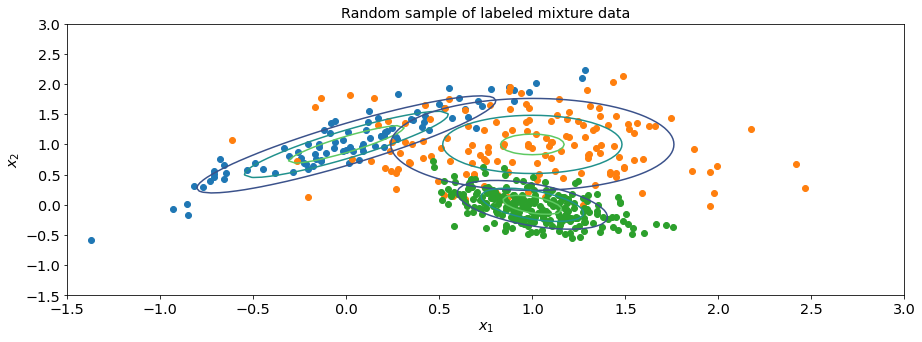

In [5]:
# create a grid for x-axis and y-axis
bins=np.zeros((2,100))
bins[0,:] = np.linspace(-1.5,3,100)
bins[1,:] = np.linspace(-1.5,3,100)

# compute the conditional density
f = fxy(mu,Sigma,bins)

#generate a dataset
x,y =  GenerateData(pi,mu,Sigma,500)

for i in range(0,mu.shape[0]):
    plt.contour(bins[0,:],bins[1,:],f[i,:,:].T, 3) # plot the contours
    plt.scatter(x[y==i,0],x[y==i,1]) # plot the points
    
plt.xlabel(r'$x_1$')    
plt.ylabel(r'$x_2$')
plt.title('Random sample of labeled mixture data')

plt.show()

## 3. Estimate the model with labels (MLE estimates)

In [6]:
def EstimateMixtureModel(x,y):
    
    Y = np.unique(y) # get the unique list of labels
    K = Y.size # number of unique labels
    
    pi = np.zeros(K)
    mu = np.zeros((K,x.shape[1]))
    Sigma = np.zeros((K,x.shape[1],x.shape[1]))
    
    # estimate the parameters for every unique point with the MLE estimates 
    for k in range(K):
        idx = (y==Y[k])
        pi[k] = np.sum(idx)/y.size
        mu[k,:] = np.mean(x[idx,:],axis=0)
        Sigma[k,:,:] = np.cov(x[idx,:].T)
        
    return pi, mu, Sigma

In [7]:
pih,muh,Sigmah = EstimateMixtureModel(x,y)

## 4. Bayes classifier
This provides the (posterior) probability that a point in feature space comes from a given class $\gamma_{k}(x)=\mathbb P(X=x|Y=k)$ and equals using Bayes rule

$$
\gamma_{k}(x) = \frac{\pi_k \; f_{X|Y=k}(x; \mu_k, \Sigma_k)}{\sum_{k\in{\mathcal K}} \pi_k \;f_{X|Y=k}(x; \mu_k, \Sigma_k)}.
$$

In [8]:
def Posterior(pi,mu,Sigma,bins):
    K = pi.size
    
    p = np.zeros((K,bins.shape[1],bins.shape[1]))
    
    for i in range(0,bins.shape[1]):
        for j in range(0,bins.shape[1]):
                 
            denom = 0
            # for every quantile, calculate the probability of it being in a certain class
            # divide by the sum of probabilities for that point, across that class
            # what results is the probability of the point (i,j) being in class k
            for k in range(0,K):
                 p[k,i,j] = st.multivariate_normal.pdf([bins[0,i],bins[1,j]],mu[k,:],Sigma[k,:,:])*pi[k]
                 denom += p[k,i,j]

            for k in range(0,K):
                 p[k,i,j] /= denom
                 
    return p

In [9]:
# compute the posterior using true model parameters
p = Posterior(pi,mu,Sigma,bins)
# compute the posterior using estimated model parameters
ph = Posterior(pih,muh,Sigmah,bins)

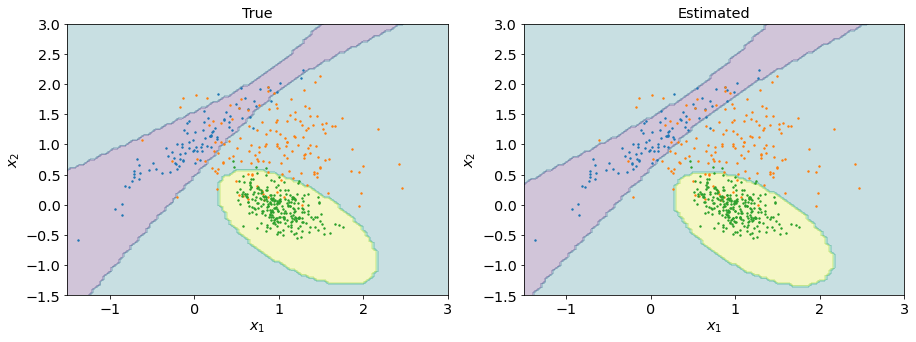

In [10]:
# plot the results
plt.subplot(1,2,1)
plt.contourf(bins[0,:],bins[1,:],np.argmax(p,axis=0).T,alpha=0.25)

for i in range(0,mu.shape[0]):
    plt.scatter(x[y==i,0],x[y==i,1],s=2)
    
plt.xlabel(r'$x_1$')    
plt.ylabel(r'$x_2$')
plt.title('True')

plt.subplot(1,2,2)
plt.contourf(bins[0,:],bins[1,:],np.argmax(ph,axis=0).T, alpha=0.25)

for i in range(0,mu.shape[0]):
    plt.scatter(x[y==i,0],x[y==i,1],s=2)
    
plt.xlabel(r'$x_1$')    
plt.ylabel(r'$x_2$')
plt.title('Estimated')
plt.show()

## 5. Estimate the model without labels (EM algorithm)

Responsibilities for the E-step at iteration $m$ for data point $n$ in class $k$ is
$$
\gamma_{n,k}^m = \frac{\pi_k^m \; f_{X_n|Y_n=k}(x_n; \mu_k^m, \Sigma_k^m)}{\sum_{k\in{\mathcal K}} \pi_k^m \;f_{X_n|Y_n=k}(x_n; \mu_k^m, \Sigma_k^m)},
$$
where the probability that data point $n$ occurs given that it is in class $k$ is
$$
f_{X_n|Y_n=k}(x_n; \mu_k^m, \Sigma_k^m) = \frac{1}{\sqrt{(2\pi)^d\det(\Sigma_k^m)}} \exp\{-\tfrac{1}{2}(x_n-\mu_k^m)^\intercal(\Sigma_k^m)^{-1}(x_n-\mu_k^m)\}.
$$

The M-step update rules are for class $l$
$$
\pi_l^{m+1} = \frac{\sum_{n\in\mathcal{N}} \gamma_{n,l}^m}{\sum_{n\in\mathcal{N},k\in\mathcal{K}} \gamma_{n,l}^m},
$$

$$
\mu_l^{m+1} = \frac{\sum_{n\in\mathcal{N}} x_n \gamma_{n,l}^m}{\sum_{n\in\mathcal{N}} \gamma_{n,l}^m},
$$

$$
\Sigma_{l,ij}^{m+1} = \frac{\sum_{n\in\mathcal{N}} (x_{n,i}-\mu_{l,i}^{m+1})(x_{n,j}-\mu_{l,j}^{m+1}) \gamma_{n,l}^m}{\sum_{n\in\mathcal{N}} \gamma_{n,l}^m}.
$$

For more information on how to derive them, see the course material.



In [11]:
# this function represents the e-step
def Reponsibilities(x,pi,mu,Sigma):
    
    K = pi.size
    
    g = np.zeros((K, x.shape[0]))
    
    for n in range(0,x.shape[0]):
        
        denom = 0
                
        for k in range(0,K):
            g[k,n] = st.multivariate_normal.pdf(x[n,:], mu[k,:].T, Sigma[k,:,:])*pi[k]
            #posterior probability that point n is in state k
            # similar to what was in the "Bayes" function, except here we are given 
            # a data point as opposed to calculating the probability for an arbitrary point
            # in feature space
            denom += g[k,n]
            
        for k in range(0,K):
            g[k,n] /= denom
            
    return g

In [12]:
def EM(x, pi, mu, Sigma, iter):
    
    K = pi.size
    d = x.shape[1]
        
    for m in range(iter):
        
        # e-step
        gamma = Reponsibilities(x,pi,mu,Sigma)
        
        #m-step
        #
        
        #  compute update to pi
        numer = np.sum(gamma, axis=1) # sum_n  gamma_{n,k} gives array shape (1,K)
        denom = np.sum(numer) # sum_{n,k}  gamma_{n,k}
        pi = numer / denom # (1,3) array
        
        #  compute update to mu
        numer = np.matmul(gamma, x)   # sum_n x_{n,l} gamma_{n,k} gives array shape (K,d) 
        sum_gamma = np.sum(gamma, axis=1) # sum_n  gamma_{n,k} gives array shape (1,K)
        for k in range(0,K):
            mu[k,:] = numer[k,:]/sum_gamma[k]
                        
        #  compute update to Sigma
        for k in range(0,K):
            for i in range(0,d):
                for j in range(0,d):
                    Sigma[k,i,j] = np.sum( (x[:,i]-mu[k,i])*(x[:,j]-mu[k,j])*gamma[k,:] )/sum_gamma[k]

    print('   -- estimated parameters -----')
    print(pi, '\n\n', mu, '\n\n', Sigma, '\n\n')
            
    return pi, mu, Sigma

In [13]:
def InitialGuess(x,K):
    # generate an initial guess depending on the number of classes that are specified

    pi_h = np.ones(K)/K
    mu_h = np.mean(x,axis=0)
    Sigma_h = np.cov(x.T)

    pi0 = pi_h * np.random.uniform(0.99,1.01,K)
    pi0 = pi0 / sum(pi0)

    mu0 = np.tile(mu_h,(K,1)) * np.random.uniform(0.99,1.01,(K,2))

    Sigma0 = np.tile(Sigma_h,(K,1,1))
    
    return pi0, mu0, Sigma0

In [29]:
# generate an initial guess using a list of classes

Kfitmax = 8 # largest number of possible classes
pe = np.empty((Kfitmax,Kfitmax,bins.shape[1],bins.shape[1]))
pie = np.empty((Kfitmax,Kfitmax))
mue = np.empty((Kfitmax,Kfitmax,2))
Sigmae = np.empty((Kfitmax,Kfitmax,2,2))

# fitting the parameters using Kfit classes
for Kfit in range (2,Kfitmax+1):
    
    print('-------- Kfit = ', Kfit, '-------- ')
    
    pi0,mu0,Sigma0 = InitialGuess(x,Kfit)

    print('   -- initial guess -- ')
    print(pi0, '\n\n', mu0, '\n\n', Sigma0, '\n\n')

    # use EM to update the estimate
    thispie, thismue, thisSigmae = EM(x, pi0, mu0, Sigma0, 100)
    pie[Kfit-1,0:Kfit] = thispie
    mue[Kfit-1,0:Kfit,:] = thismue
    Sigmae[Kfit-1,0:Kfit,:,:] = thisSigmae
    
    # compute the posterior distribution
    pe[Kfit-1,0:Kfit,:,:] = Posterior(thispie, thismue, thisSigmae, bins)

-------- Kfit =  2 -------- 
   -- initial guess -- 
[0.49917191 0.50082809] 

 [[0.80720264 0.47778826]
 [0.8084078  0.46907436]] 

 [[[ 0.30632801 -0.08438281]
  [-0.08438281  0.4193394 ]]

 [[ 0.30632801 -0.08438281]
  [-0.08438281  0.4193394 ]]] 


   -- estimated parameters -----
[0.49478035 0.50521965] 

 [[ 0.60611028  0.99614585]
 [ 1.00098382 -0.03785573]] 

 [[[ 0.47524721  0.06466308]
  [ 0.06466308  0.25024245]]

 [[ 0.06253783 -0.02799618]
  [-0.02799618  0.05428329]]] 


-------- Kfit =  3 -------- 
   -- initial guess -- 
[0.33268589 0.33396839 0.33334572] 

 [[0.8107672  0.47395724]
 [0.79803952 0.47241704]
 [0.80427596 0.4764367 ]] 

 [[[ 0.30632801 -0.08438281]
  [-0.08438281  0.4193394 ]]

 [[ 0.30632801 -0.08438281]
  [-0.08438281  0.4193394 ]]

 [[ 0.30632801 -0.08438281]
  [-0.08438281  0.4193394 ]]] 


   -- estimated parameters -----
[0.50788381 0.17501391 0.31710228] 

 [[ 0.98845967 -0.03255724]
 [ 0.07310435  1.06238551]
 [ 0.91702657  0.95978807]] 

 [[[ 0.0

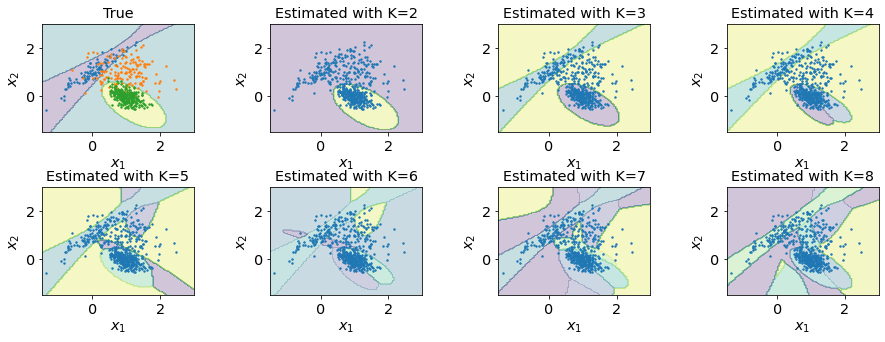

In [30]:
# plot the results
plt.subplot(2, int(np.ceil(Kfitmax/2)),1)
plt.contourf(bins[0,:],bins[1,:],np.argmax(p,axis=0).T,alpha=0.25)

for i in range(0,mu.shape[0]):
    plt.scatter(x[y==i,0],x[y==i,1],s=2)
    
plt.xlabel(r'$x_1$')    
plt.ylabel(r'$x_2$')
plt.title('True')

for Kfit in range(2,Kfitmax+1):
    plt.subplot(2, int(np.ceil(Kfitmax/2)),Kfit)
    plt.contourf(bins[0,:],bins[1,:],np.argmax(pe[Kfit-1,:,:,:],axis=0).T, alpha=0.25)
    plt.scatter(x[:,0],x[:,1],s=2)

    plt.xlabel(r'$x_1$')    
    plt.ylabel(r'$x_2$')
    plt.title(r'Estimated with K=' + str(Kfit))

plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show()

## 6. Model selection

We try to select the "best model" using the Bayesian Information Criterion
$$
BIC(\text{Model }j) = -\ell_{j}(\hat{\theta}_{j}) + \frac{1}{2} d_j \log(n),
$$
where $d_j$ is the number of free parameters in the model, $n$ is the number of observations and $\ell_{j}$ is the log-likelihood.

In [31]:
def loglike(x,pi,mu,Sigma):    
    # see formula (3.29-3.30) in the book for the derivation of the log-likelihood
    gamma = Reponsibilities(x,pi,mu,Sigma)
    logl = 0
    for k in range(pi.shape[0]):
        for n in range(x.shape[0]):
            logl += gamma[k,i] * ( np.log(pi[k]) + st.multivariate_normal.logpdf(x[n,:], mu[k,:].T, Sigma[k,:,:]) - np.log(gamma[k,i]))
            
    return logl

In [32]:
def BIC(x,pi,mu,Sigma):
    K = pi.shape[0]
    n = x.shape[0]
    d = x.shape[1]
    
    # number of free parameters
    # pi : (K-1)
    # mu : K*d
    # Sigma : K*(d*(d+1))/2
    return -loglike(x,pi,mu,Sigma) + 0.5*((K-1) + d*K + K*d*(d+1)*0.5)*np.log(n)

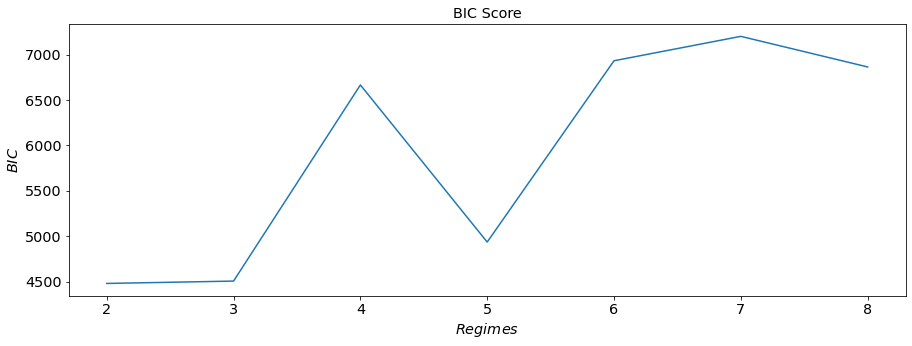

In [33]:
bic = np.empty((Kfitmax,1))
ll = np.empty((Kfitmax,1))

# fitting the parameters using Kfit classes
for Kfit in range (2,Kfitmax+1):
    # get log-likelihood and the BIC criterion
    bic[Kfit-1] = BIC(x, pie[Kfit-1,0:Kfit], mue[Kfit-1,0:Kfit,:], Sigmae[Kfit-1,0:Kfit,:,:])
    ll[Kfit-1] = loglike(x, pie[Kfit-1,0:Kfit], mue[Kfit-1,0:Kfit,:], Sigmae[Kfit-1,0:Kfit,:,:])
    
# plot the BIC score for model selection
plt.plot(np.linspace(2,Kfitmax,Kfitmax-1),bic[1:Kfitmax])
plt.xlabel(r'$Regimes$')    
plt.ylabel(r'$BIC$')
plt.title('BIC Score')
plt.show()